In [1]:
!pip install focal_loss

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from focal_loss import BinaryFocalLoss

def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Build the model
    s = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[s], outputs=[outputs])
    model.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=4), metrics=['accuracy',dice_coef, iou_score])
    model.summary()

    return model


In [4]:
from tensorflow.keras import backend as K 
import tensorflow as tf

In [5]:
def iou_score(y_pred, y_true):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  y_true = tf.reshape(y_true, [-1])
  y_pred = tf.reshape(y_pred, [-1])
  intersection = tf.reduce_sum(y_true * y_pred)
  score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
  return score

def dice_coef(y_test, y_pred):
    smooth = 1.
    
    y_true_f = K.flatten(y_test)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [6]:
from keras.utils import normalize
import os
from tqdm import tqdm
import cv2
from PIL import Image
import random
import numpy as np
from datetime import datetime 
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau


In [20]:
#loading image paths
image_directory = 'C:/Users/PRATIK PAL/Desktop/CVC/Original/'
mask_directory = 'C:/Users/PRATIK PAL/Desktop/CVC/Ground_Truth/'

SIZE = 256
image_dataset = []    
mask_dataset = []  

In [21]:
#reading the images, resize them and stored in a list
images = os.listdir(image_directory)
for i, image_name in tqdm(enumerate(images),total=len(images)):    
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#reading the masks, resize them and stored in a list
masks = os.listdir(mask_directory)
for i, image_name in tqdm(enumerate(masks),total=len(masks)):
    if (image_name.split('.')[1] == 'tif'):
        mask = cv2.imread(mask_directory+image_name, 0)
        mask = Image.fromarray(mask)
        mask = mask.resize((SIZE, SIZE))
        mask_dataset.append(np.array(mask))

#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

100%|██████████| 200/200 [00:00<00:00, 585.18it/s]


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                   test_size = 0.2, random_state = 0)

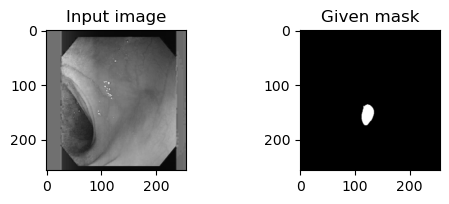

In [23]:
#view few sample(just for checking)
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(6, 4))
plt.subplot(2,2,1)
plt.title('Input image')
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')

plt.subplot(2,2,2)
plt.title('Given mask')
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')

In [24]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [25]:
from keras.models import load_model
model=unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
#model= load_model('C:/Users/PRATIK PAL/PycharmProjects/data/UNET/cvcmodel1.h5',custom_objects={'dice_coef':dice_coef,
                    #'iou_score':iou_score,'BinaryFocalLoss': BinaryFocalLoss,'dice_coef_loss':dice_coef_loss})

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 128, 128, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [26]:
callback = [
    ModelCheckpoint("C:/Users/PRATIK PAL/PycharmProjects/data/UNET/cvcmodel2.h5"), 
    CSVLogger('C:/Users/PRATIK PAL/PycharmProjects/data/UNET/epoch2.csv'),
    TensorBoard(),EarlyStopping(monitor='val_accuracy',patience=6,verbose=1,restore_best_weights=True)
       ]

In [27]:
#training the data
unet_history = model.fit(X_train,y_train,batch_size=20,epochs=12,steps_per_epoch=20,
             validation_data=(X_test, y_test),shuffle=False,callbacks=callback)

Epoch 1/12
20/20 [==============================] - 65s 3s/step - loss: 0.0313 - accuracy: 0.8718 - dice_coef: 0.1456 - iou_score: 0.0786 - val_loss: 0.0238 - val_accuracy: 0.9088 - val_dice_coef: 0.1316 - val_iou_score: 0.0706
Epoch 2/12
20/20 [==============================] - 67s 3s/step - loss: 0.0235 - accuracy: 0.9074 - dice_coef: 0.1406 - iou_score: 0.0757 - val_loss: 0.0217 - val_accuracy: 0.9088 - val_dice_coef: 0.1366 - val_iou_score: 0.0735
Epoch 3/12
20/20 [==============================] - 65s 3s/step - loss: 0.0219 - accuracy: 0.9048 - dice_coef: 0.1522 - iou_score: 0.0824 - val_loss: 0.0215 - val_accuracy: 0.9088 - val_dice_coef: 0.1440 - val_iou_score: 0.0778
Epoch 4/12
20/20 [==============================] - 64s 3s/step - loss: 0.0210 - accuracy: 0.9074 - dice_coef: 0.1512 - iou_score: 0.0819 - val_loss: 0.0207 - val_accuracy: 0.9088 - val_dice_coef: 0.1446 - val_iou_score: 0.0781
Epoch 5/12
20/20 [==============================] - 51s 3s/step - loss: 0.0204 - accurac

In [28]:
acc = model.evaluate(X_test, y_test)

2/2 [==============================] - 2s 284ms/step - loss: 0.0197 - accuracy: 0.9088 - dice_coef: 0.1580 - iou_score: 0.0858


In [29]:
acc1 = model.evaluate(X_train, y_train)

5/5 [==============================] - 4s 867ms/step - loss: 0.0197 - accuracy: 0.9061 - dice_coef: 0.1620 - iou_score: 0.0882


In [33]:
#prediction on some random sample
#test_img_number = random.randint(0, len(X_test))
test_img_number = random.randint(0, len(X_train))
test_img = X_train[test_img_number]
ground_truth=y_train[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,:] > 0.6).astype(np.uint8)

1/1 [==============================] - 0s 66ms/step


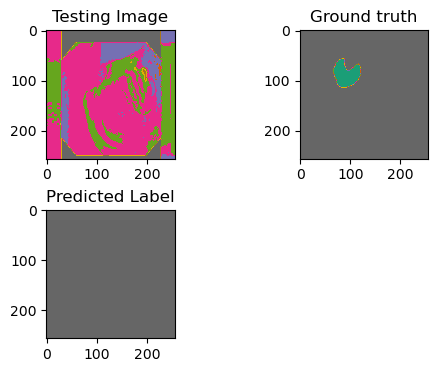

In [34]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(hspace = 0.4)
plt.subplot(2,2,1)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0],cmap = 'Dark2_r')

plt.subplot(2,2,2)
plt.title('Ground truth')
plt.imshow(ground_truth[:,:,0],cmap = 'Dark2_r')

plt.subplot(2,2,3)
plt.title('Predicted Label')
plt.imshow(prediction[:,:,0],cmap = 'Dark2_r')

In [ ]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'